In [66]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from functools import partial
import gc

%matplotlib inline 

In [2]:
# Checking the versions for TF and Keras
print(tf.__version__, keras.__version__)

2.11.0 2.11.0


In [3]:
# Ensuring the GPU's are available 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Description and Data

The goal of the project is binary classification on digital pathology scans to predict the present of metastatic cancer. We will explore the directories inside Kaggle to get a better idea of the number of samples and their size. 

In [4]:
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'

In [5]:
train_samples = os.listdir(train_path)
test_samples = os.listdir(test_path)
print(len(train_samples), len(test_samples))

220025 57458


In [6]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
# Add extension to the train_labels for DataGenerator
train_labels['id'] = train_labels['id']+'.tif'
# Change label type to string for DataGenerator
train_labels['label'] = train_labels['label'].astype(str)
train_labels.shape

(220025, 2)

In [7]:
# Create a dataframe out of test_labels as well
test_labels =  pd.DataFrame(test_samples, columns=['id'])

In [8]:
# Check the size of an image
image = cv2.imread(train_path+train_samples[1])
image.shape

(96, 96, 3)

There are a total of 220,025 training images and a total of 57,458 testing images.The dataframe train_labels contains the labels for the training images.  

The images are 96x96 and are color images, giving us an input array of **96 by 96 by 3**

## Some EDA

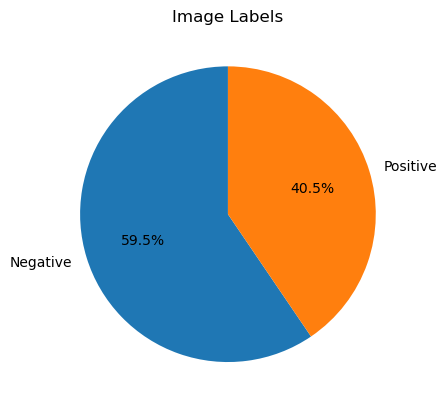

In [9]:
# Create a dataframe to show class counts
train_labels_counts = train_labels['label'].value_counts().reset_index()

plt.pie(train_labels_counts['label'].values, 
        labels=['Negative', 'Positive'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Image Labels')
plt.show()

We see that there isn't a significant class imbalance between the positive and negative labels.

In [91]:
def show_image(val):
    """Given positive or negative value plot 4 images"""
    plt.figure(1, figsize=(12, 12))
    for i, image_title in enumerate(train_labels[train_labels['label'] == str(val)]['id'].sample(6)):
        imgs = cv2.imread(train_path+image_title)
        plt.subplot(2, 3, i+1)
        plt.imshow(imgs)

Negative Images


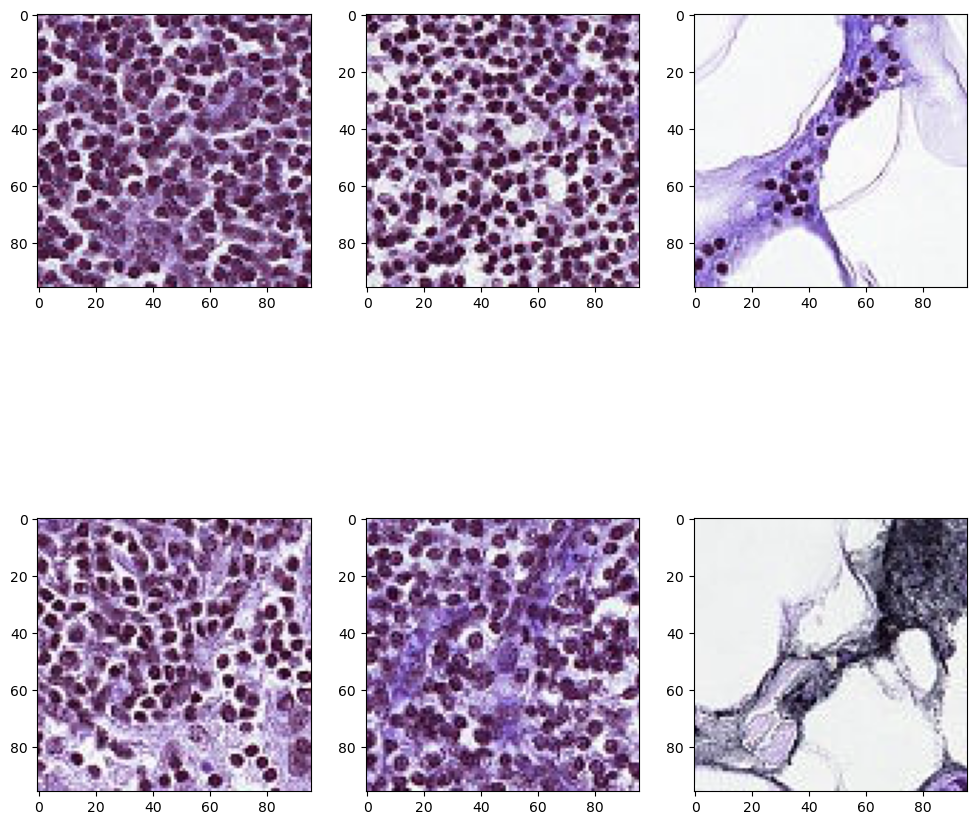

In [92]:
# Show some images
print('Negative Prediction for Cancer')
show_image(0)

Positive Images


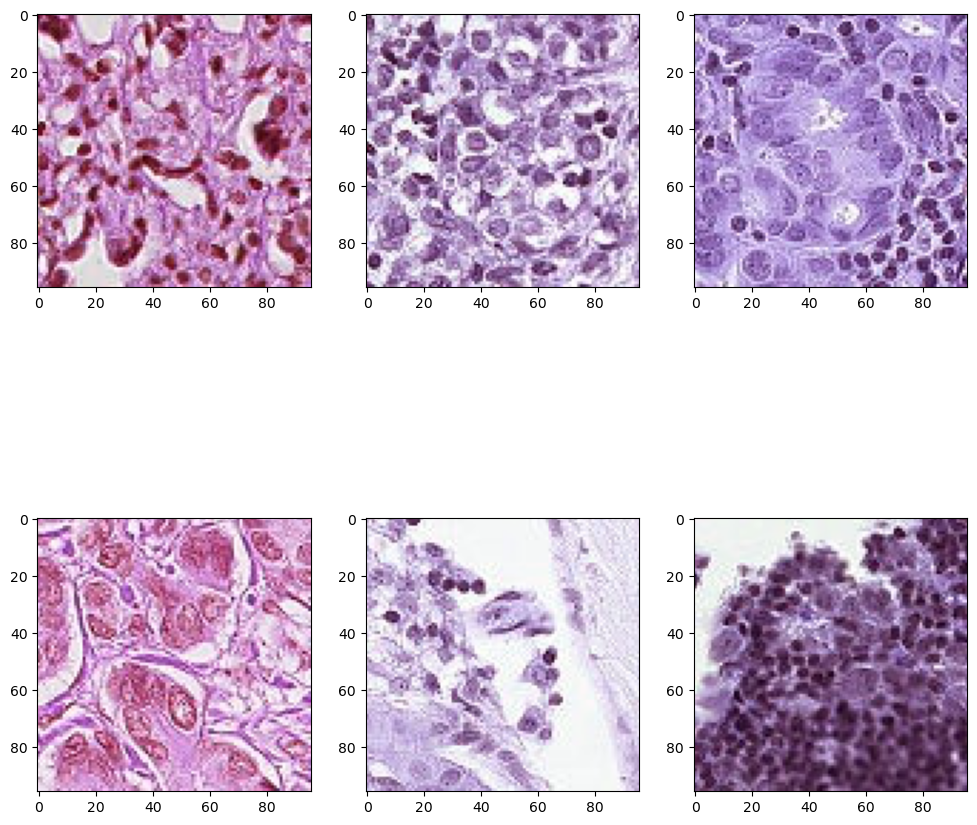

In [93]:
print('Positive Prediction for Cancer')
show_image(1)

## Pipelines for the Data

In [13]:
# Normalize training and testing sets
train_gen = keras.preprocessing.image.ImageDataGenerator(
                               rescale=1./255.0, # Rescale inputs 
                               validation_split=0.20)

test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.0)

In [105]:
# Create the training and validation test batches
train_generator = train_gen.flow_from_dataframe(
                    dataframe=train_labels,
                    directory=train_path,
                    x_col="id",
                    y_col="label",
                    target_size=(96, 96),
                    batch_size=10,
                    color_mode='rgb',
                    class_mode="binary",
                    subset='training',
                    shuffle=True,
                    seed=42
                )

validation_generator = train_gen.flow_from_dataframe(
                        dataframe=train_labels,
                        directory=train_path,
                        x_col="id",
                        y_col="label",
                        target_size=(96, 96),
                        batch_size=32,
                        color_mode='rgb',
                        class_mode="binary",
                        subset='validation',
                        shuffle=True,
                        seed=42
                    )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [106]:
# Create the test batch
test_generator = test_gen.flow_from_dataframe(
                        dataframe=test_labels,
                        directory=test_path,
                        x_col="id",
                        target_size=(96, 96),
                        batch_size=1,
                        color_mode='rgb',
                        class_mode=None,
                        shuffle=False,
                        seed=42
                    )

Found 57458 validated image filenames.


## Model Architecture

Our first basic model will be structured as follows 

1) Convolution Layer  (32 filters)  
2) Pooling Layer (size 2)  
3) Convolution Layer  (64 filters)  
4) Pooling Layer (size 2)  
5) Flattening Layer  
6) Dense Layer (16 neurons)  
7) Activation Layer (Sigmoid)  

Trained for 5 epochs.   

This is a straightforward model, we will add more layers afterwards and create a model with a different architecture

In [16]:
# Create a default layer with general parameters
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=(3,3), activation='relu')

In [100]:
basic_model = keras.models.Sequential([
                        DefaultConv2D(filters=32, kernel_size=(6,6), input_shape=(96, 96, 3)),
                        keras.layers.MaxPooling2D(pool_size=2), # Pool
                        DefaultConv2D(filters=64),
                        keras.layers.MaxPooling2D(pool_size=2), # Pool
                        keras.layers.Flatten(),
                        keras.layers.Dense(units=16, activation='relu'),
                        keras.layers.Dense(units=1, activation='sigmoid'),
                    ])

In [101]:
basic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 91, 91, 32)        3488      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 43, 43, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 28224)             0         
                                                                 
 dense_3 (Dense)             (None, 16)               

In [102]:
basic_model.compile(loss="binary_crossentropy", # Loss function
                optimizer="adam", # Gradient Descent
                metrics=["accuracy", "AUC"])

In [108]:
basic_model_history = basic_model.fit(train_generator,
                            epochs=5,
                            validation_data =validation_generator)

Epoch 1/5
17602/17602 [==============================] - 753s 43ms/step - loss: 0.4618 - accuracy: 0.7887 - auc: 0.8565 - val_loss: 0.4225 - val_accuracy: 0.8130 - val_auc: 0.8836
Epoch 2/5
17602/17602 [==============================] - 693s 39ms/step - loss: 0.4164 - accuracy: 0.8155 - auc: 0.8863 - val_loss: 0.4503 - val_accuracy: 0.7904 - val_auc: 0.8745
Epoch 3/5
17602/17602 [==============================] - 486s 28ms/step - loss: 0.3721 - accuracy: 0.8356 - auc: 0.9104 - val_loss: 0.3608 - val_accuracy: 0.8404 - val_auc: 0.9169
Epoch 4/5
17602/17602 [==============================] - 427s 24ms/step - loss: 0.3421 - accuracy: 0.8506 - auc: 0.9249 - val_loss: 0.3922 - val_accuracy: 0.8267 - val_auc: 0.9051
Epoch 5/5
17602/17602 [==============================] - 404s 23ms/step - loss: 0.3210 - accuracy: 0.8604 - auc: 0.9341 - val_loss: 0.3528 - val_accuracy: 0.8461 - val_auc: 0.9202


### Accuracy vs Epochs for the basic model  

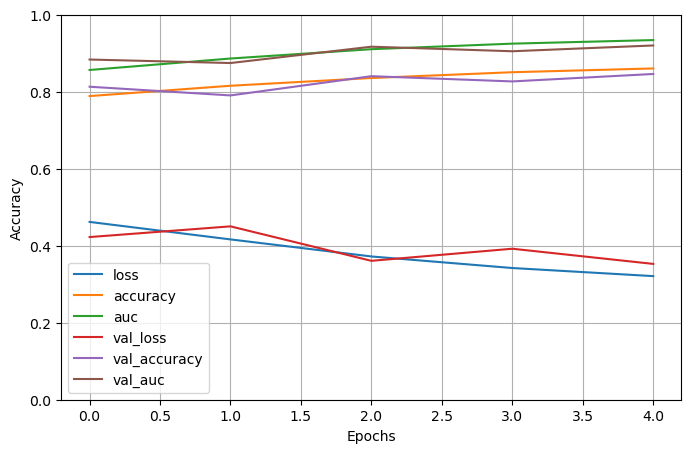

In [109]:
pd.DataFrame(basic_model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [110]:
basic_predictions = basic_model.predict(test_generator)

57458/57458 [==============================] - 274s 5ms/step


<AxesSubplot:ylabel='Frequency'>

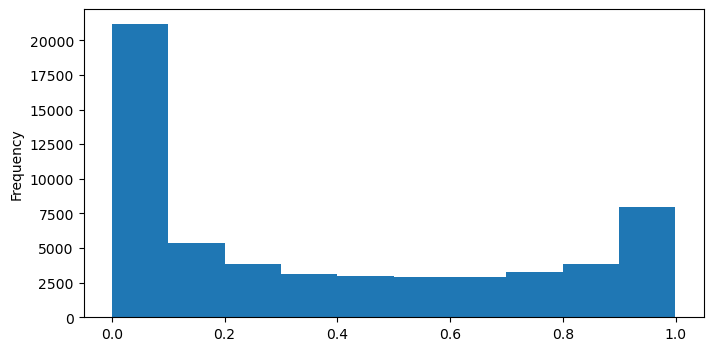

In [111]:
basic_test_predictions = test_labels.copy()
basic_test_predictions['model_probability'] = basic_predictions
plt.figure(1, figsize=(8, 4))
basic_test_predictions['model_probability'].plot.hist()

In [112]:
basic_test_predictions['labels'] = basic_test_predictions['model_probability'].apply(lambda x: x> .5).replace({True: 1, False: 0})
basic_test_predictions['id'] = basic_test_predictions['id'].str.replace('.tif', '')
basic_test_predictions.to_csv('Basic Model Predictions.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


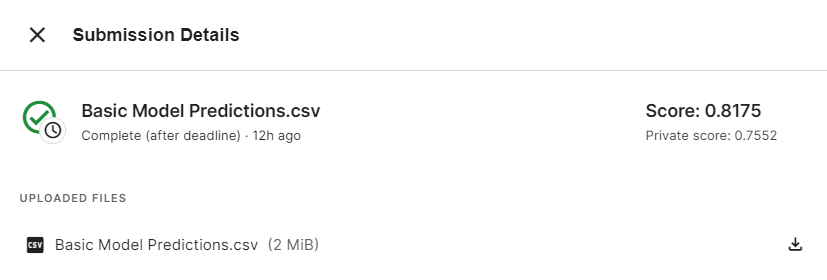

Not too bad for a simple model. We will add more layers to train another model for slightly longer.

Convolution Layer  (16 filters)  
Pooling Layer (size 2)  
Convolution Layer  (32 filters)  
Convolution Layer  (32 filters)  
Normalization Layer  
Pooling Layer (size 2)  
Convolution Layer  (64 filters)   
Convolution Layer  (64 filters)  
Normalization Layer  
Pooling Layer (size 2)  
Flattening Layer   
Dense Layer (64 neurons)  
Dense Layer (32 neurons)    
Activation Layer (Sigmoid)  

This will be trained for 10 epochs (history only shows 5, ran out of memory so trained additional 5 epochs later on)

In [17]:
# Combine sequential values for the model
model = keras.models.Sequential([
                DefaultConv2D(filters=16, kernel_size=(6,6), input_shape=(96, 96, 3)),
                keras.layers.MaxPooling2D(pool_size=2), # Pool
                DefaultConv2D(filters=32),
                DefaultConv2D(filters=32),
                keras.layers.BatchNormalization(),
                keras.layers.MaxPooling2D(pool_size=2), # Pool
                DefaultConv2D(filters=64),
                DefaultConv2D(filters=64),
                keras.layers.BatchNormalization(),
                keras.layers.MaxPooling2D(pool_size=2), # Pool
                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation='relu'),
                keras.layers.Dense(units=32, activation='relu'),
                keras.layers.Dense(units=1, activation='sigmoid'),
            ])

In [18]:
# Get a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 91, 91, 16)        1744      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 41, 41, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0

In [19]:
# Get individual layer of the model
model.layers

In [20]:
model.compile(loss="binary_crossentropy", # Loss function
            optimizer="adam", # Gradient Descent
            metrics=["accuracy", "AUC"])

In [23]:
history = model.fit(train_generator,
                    epochs=5,
                    validation_data =validation_generator)

Epoch 1/5
17602/17602 [==============================] - 366s 21ms/step - loss: 0.2563 - accuracy: 0.8953 - auc: 0.9573 - val_loss: 0.3205 - val_accuracy: 0.8763 - val_auc: 0.9427
Epoch 2/5
17602/17602 [==============================] - 374s 21ms/step - loss: 0.2477 - accuracy: 0.8982 - auc: 0.9601 - val_loss: 0.2830 - val_accuracy: 0.8835 - val_auc: 0.9510
Epoch 3/5
17602/17602 [==============================] - 385s 22ms/step - loss: 0.2356 - accuracy: 0.9044 - auc: 0.9640 - val_loss: 0.5496 - val_accuracy: 0.8230 - val_auc: 0.8887
Epoch 4/5
17602/17602 [==============================] - 395s 22ms/step - loss: 0.2237 - accuracy: 0.9101 - auc: 0.9675 - val_loss: 0.3530 - val_accuracy: 0.8525 - val_auc: 0.9443
Epoch 5/5
17602/17602 [==============================] - 382s 22ms/step - loss: 0.2137 - accuracy: 0.9154 - auc: 0.9702 - val_loss: 0.2955 - val_accuracy: 0.8822 - val_auc: 0.9492


### Accuracy vs Epochs for the basic model  

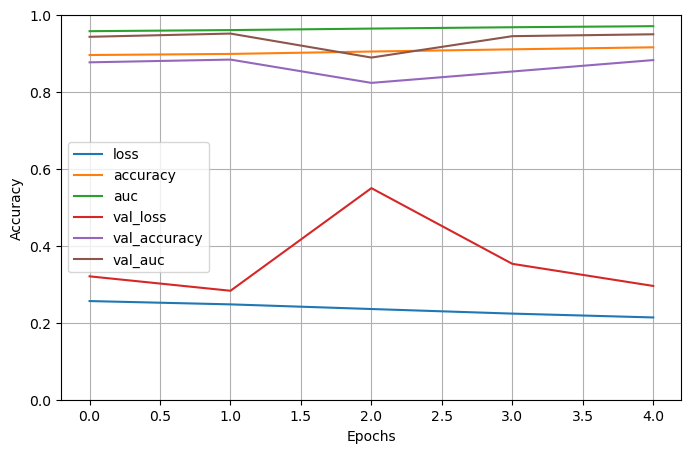

In [30]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Results

In [52]:
# Save the model, it took a while to train, it is important to be able 
# recover the model if need be
model.save("cancer_model.h5")

In [69]:
predictions = model.predict(test_generator)

57458/57458 [==============================] - 199s 3ms/step


<AxesSubplot:ylabel='Frequency'>

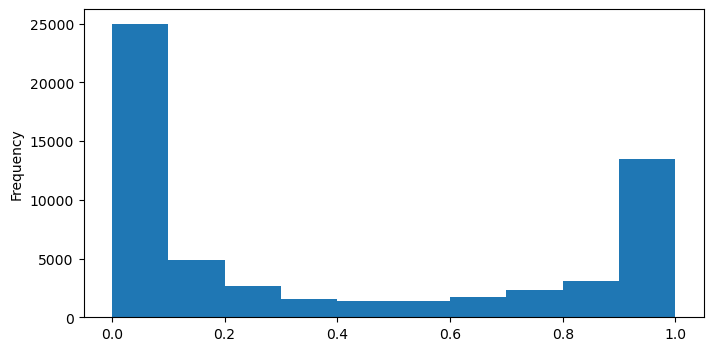

In [99]:
# Plot a histogram of the sigmoid function
test_labels['model_probability'] = predictions
plt.figure(1, figsize=(8, 4))
test_labels['model_probability'].plot.hist()

The number of negative predictions is definitely lower for this model compared to the basic model based on just the histogram.

In [72]:
test_predictions = test_labels.copy()
test_predictions['labels'] = test_predictions['model_probability'].apply(lambda x: x> .5).replace({True: 1, False: 0})
test_predictions['id'] = test_predictions['id'].str.replace('.tif', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [47]:
test_predictions.to_csv('Cancer Detection Predictions.csv')

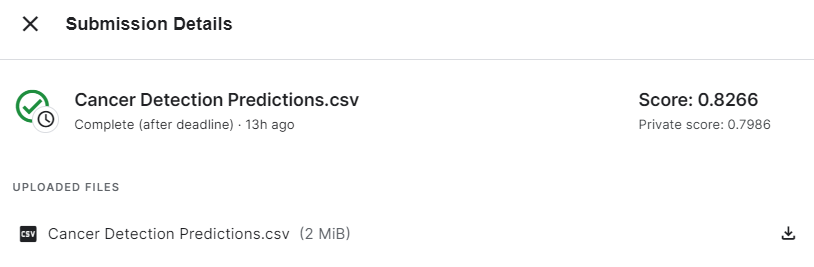

## Conclusion 

The model with the added convolution layers and dropping performed better (.8266 vs 0.8175)  

We can augment some of these by flipping them on their x and y axis, creating additional data to train on. We can do this for the positive class till the class is perfectly balanced at 50-50. This should aid our accuracy, and more importantly our **recall**. For classification tasks like cancer detection, a higher recall score is a significant priority.